# Access Copernicus Land, Atmosphere and Marine data

This notebook allows to access to Copernicus data using Copernicus APIs.
The data used in this notebook are stored in memory using these services without downloading data.

## Import libraries
List of relevant libraries used: 
- matplotlib
- xarray
- pydap
- cartopy
- numpy
- lxml

In [ ]:
# #Install the following libraries using pip if not working on Binder (it may be required to restart the kernel):
#!pip install lxml
#!pip install cdsapi
#!pip install hda

In [1]:
import matplotlib.pyplot as plt
import xarray as xr
import getpass
import json
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.patches as mpatches
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cdsapi
from urllib.request import urlopen

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

---

## Copernicus Marine data from OPeNDAP API

Reference material for this code:
- https://help.marine.copernicus.eu/en/articles/5182598-how-to-consume-the-opendap-api-and-cas-sso-using-python
- https://www.youtube.com/watch?v=ZJoRZYiMQcM&ab_channel=CopernicusMarineService

First of all define a function able to retrieve the data from Copernicus Marine API, using OPeNDAP. The data used for this example can be accessed from [here](https://resources.marine.copernicus.eu/product-detail/MEDSEA_ANALYSISFORECAST_PHY_006_013/DATA-ACCESS):

In [ ]:
# #! /usr/bin/env python3
# # -*- coding: utf-8 -*-
# __author__ = "Copernicus Marine User Support Team"
# __copyright__ = "(C) 2022 E.U. Copernicus Marine Service Information"
# __credits__ = ["E.U. Copernicus Marine Service Information"]
# __license__ = "MIT License - You must cite this source"
# __version__ = "202104"
# __maintainer__ = "D. Bazin, E. DiMedio, C. Giordan"
# __email__ = "servicedesk dot cmems at mercator hyphen ocean dot eu"

def copernicusmarine_datastore(dataset, username, password):
    from pydap.client import open_url
    from pydap.cas.get_cookies import setup_session
    cas_url = 'https://cmems-cas.cls.fr/cas/login'
    session = setup_session(cas_url, username, password)
    session.cookies.set("CASTGC", session.cookies.get_dict()['CASTGC'])
    database = ['my', 'nrt']
    url = f'https://{database[0]}.cmems-du.eu/thredds/dodsC/{dataset}'
    try:
        data_store = xr.backends.PydapDataStore(open_url(url, session=session)) # needs PyDAP >= v3.3.0 see https://github.com/pydap/pydap/pull/223/commits 
    except:
        url = f'https://{database[1]}.cmems-du.eu/thredds/dodsC/{dataset}'
        data_store = xr.backends.PydapDataStore(open_url(url, session=session)) # needs PyDAP >= v3.3.0 see https://github.com/pydap/pydap/pull/223/commits
    return data_store

The **id** and **password** are the same used for logging in the Copernicus Marine website.

In [ ]:
# Required the data using the function copernicusmarine_datastore
data_store = copernicusmarine_datastore('med-cmcc-tem-an-fc-d', 'CMEMS_ID', 'CMEMS_PASS')

The data_store variable can be open with xarray library, using the open_dataset function:

In [ ]:
DS = xr.open_dataset(data_store).sel(time='2021-01-01', method='nearest')
DS

Is possible to slice the xarray dataset using lat/lon and creating a cropped dataset over the area of interest:

In [ ]:
min_lon = 12
min_lat = 40 
max_lon = 19
max_lat = 46 


cropped_ds = DS.sel(lat=slice(min_lat,max_lat), lon=slice(min_lon,max_lon))
cropped_ds

The dataset can be plotted or used for further analysis:

In [ ]:
temp_mod = cropped_ds['thetao'].sel(depth=0,method='nearest').squeeze()


f = plt.figure(figsize=(10,8))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
gl= ax.gridlines(crs=ccrs.PlateCarree(),draw_labels=True)
gl.right_labels=False
gl.top_labels=False
ax.add_feature(cfeature.LAND, zorder=1,edgecolor='k')
ax.set_extent([11,20, 39, 46],crs=ccrs.PlateCarree())

f.suptitle('Adriatic Sea surface temperature', fontsize=28)
im = ax.pcolor(temp_mod['lon'].data,temp_mod['lat'].data, temp_mod, cmap='plasma')
cbar= f.colorbar(im,ax=ax)
cbar.set_label('°C', rotation =270, fontsize=23,labelpad=15)

---

## Copernicus Atmosphere Monitoring Service (CAMS) data using cdsapi library

Reference: https://github.com/ecmwf/cdsapi/issues/25

The id and key to access CAMS API can be retrieved as explained at this link: https://ads.atmosphere.copernicus.eu/api-how-to.

In [ ]:
c = cdsapi.Client("https://ads.atmosphere.copernicus.eu/api/v2","ads_key") #change ads_key

It is possible to define the download parameters using the tab form provided by CAMS (https://ads.atmosphere.copernicus.eu/cdsapp#!/dataset/cams-europe-air-quality-forecasts?tab=form) and pass them to the **retrive** function of the cdsapi library.

In [ ]:
# API request
params = {'format': 'netcdf',
        'variable': 'particulate_matter_2.5um',
        'model': 'ensemble',
        'date': '2022-04-18/2022-04-20',
        'level': '0',
        'type': 'analysis',
        'time':'00:00',
        'leadtime_hour': 0,
        'area': [48,6, 43, 13]}

# retrieve the location of the file
fl = c.retrieve('cams-europe-air-quality-forecasts', params) 

# load into memory 
with urlopen(fl.location) as f:
    ds = xr.open_dataset(f.read()).mean(dim='time')

The CAMS dataset can be plotted as follow:

In [ ]:
pm_mod = ds['pm2p5_conc'].sel(level=0,method='nearest').squeeze()


f = plt.figure(figsize=(10,8))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
gl= ax.gridlines(crs=ccrs.PlateCarree(),draw_labels=True)
gl.right_labels=False
gl.top_labels=False
ax.add_feature(cfeature.LAND, zorder=1,edgecolor='k')
ax.set_extent([5,14, 42, 49],crs=ccrs.PlateCarree())

f.suptitle('Po Valley PM2.5', fontsize=28)
im = ax.pcolor(pm_mod['longitude'].data,pm_mod['latitude'].data, pm_mod, cmap='plasma')
cbar= f.colorbar(im,ax=ax)
cbar.set_label('Concentration', rotation =270, fontsize=23,labelpad=15)

----

## WEkEO DIAS

Reference: https://www.wekeo.eu/docs/webdav-wekeodrive <br>
WEkEO HDA API: https://github.com/ecmwf/hda <br>
WEkEO > Dashboard > JupyterHub

### Install the WEkEO HDA API
Follow the instructions at this link for installation: https://www.wekeo.eu/docs/hda-python-lib
You should create a ".hdarc" file inside your user folder with your WEkEO username and password. 

For Binder upload ".hdarc" file in your folder.

In [43]:
import hda
import warnings
warnings.filterwarnings('ignore')

In [44]:
# Initialize HDA client
c = hda.Client()  #upload .hdarc file in the folder

Create the query for data request.
1. Go on WEkEO data viewer: https://www.wekeo.eu/data?view=viewer&initial=1
2. Select the data from Catalogue. For exaple ERA5 Data
3. Click on "Subset and download" on the layer menu
4. Select the parameters and then "Show API request"
5. Insert the API request in the following query variable

In [45]:
query = {
  "datasetId": "EO:ECMWF:DAT:ERA5_HOURLY_VARIABLES_ON_PRESSURE_LEVELS",
  "multiStringSelectValues": [
    {
      "name": "variable",
      "value": [
        "temperature"
      ]
    },
    {
      "name": "pressure_level",
      "value": [
        "1000"
      ]
    },
    {
      "name": "year",
      "value": [
        "2020"
      ]
    },
    {
      "name": "month",
      "value": [
        "12"
      ]
    },
    {
      "name": "day",
      "value": [
        "31"
      ]
    },
    {
      "name": "time",
      "value": [
        "12:00"
      ]
    },
    {
      "name": "product_type",
      "value": [
        "ensemble_mean"
      ]
    }
  ],
  "stringChoiceValues": [
    {
      "name": "format",
      "value": "netcdf"
    }
  ]
}

# The following line runs the query
matches = c.search(query)

# The following line prints the products returned by the query
print(matches)

SearchResults[items=1,volume=513K,jobId=rdk-X4aXC45zF2undnw7bVEgylc]


In [ ]:
fl = matches.results[0]['url']

In [ ]:
# load into memory 
with urlopen(fl) as f:
    ds = xr.open_dataset(f.read()).mean(dim='time')

In [ ]:
ds

In [ ]:
pm_mod = ds['t'].squeeze()


f = plt.figure(figsize=(10,8))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
gl= ax.gridlines(crs=ccrs.PlateCarree(),draw_labels=True)
gl.right_labels=False
gl.top_labels=False
ax.add_feature(cfeature.LAND, zorder=1,edgecolor='k')
ax.set_extent([-180,180, -90, 90],crs=ccrs.PlateCarree())

f.suptitle('Temperature', fontsize=28)
im = ax.pcolor(pm_mod['longitude'].data,pm_mod['latitude'].data, pm_mod, cmap='plasma')
cbar= f.colorbar(im,ax=ax)
cbar.set_label('K', rotation =270, fontsize=23,labelpad=15)

---

## Terrascope Copernicus Land

Reference: https://worldcover2020.esa.int/data/docs/WorldCover_PUM_V1.1.pdf <br>
https://notebooks.terrascope.be/

Use the following command to install terracatalogueclient.

In [ ]:
#!pip install --extra-index-url https://artifactory.vgt.vito.be/api/pypi/python-packages/simple terracatalogueclient

In [2]:
import datetime as dt
from terracatalogueclient import Catalogue
# initialize the catalogueclient
catalogue = Catalogue()

In [3]:
# get all collections
collections = catalogue.get_collections()
for collection in collections:
    print("{}: {}".format(collection.id, collection.properties['title']))

urn:eop:VITO:CGS_S1_GRD_L1: SENTINEL-1 Level-1 Ground Range Detected (GRD) products
urn:eop:VITO:CGS_S1_GRD_SIGMA0_L1: SENTINEL-1 Level-1 Ground Range Detected (GRD) SIGMA0 products
urn:eop:VITO:CGS_S1_SLC_L1: SENTINEL-1 Level-1 Single Look Complex (SLC) products.
urn:eop:VITO:CGS_S2_L1C: SENTINEL-2 Level-1C MSI product contains Top-of-atmosphere reflectances in cartographic geometry
urn:eop:VITO:COP_DEM_GLO_30M_COG: Copernicus Global 30 meter Digital Elevation Model dataset in COG format  
urn:eop:VITO:COP_DEM_GLO_90M_COG: Copernicus Global 90 meter Digital Elevation Model dataset in COG format
urn:eop:VITO:ESA_WorldCover_10m_2020_V1: ESA WorldCover products 10 meter COG format  
urn:eop:VITO:ESA_WorldCover_S1VVVHratio_10m_2020_V1: ESA WorldCover Sentinel-1 color image, 10 meter COG format
urn:eop:VITO:ESA_WorldCover_S2RGBNIR_10m_2020_V1: ESA WorldCover Sentinel-2 color image, 10 meter COG format
urn:eop:VITO:TERRASCOPE_S1_SLC_COHERENCE_V1: SENTINEL-1 Level-1 Single Look Complex (SLC)

In [4]:
# let's also print the data access URLs
for collection in collections:
    print("{}: {}".format(collection.id, collection.properties['title']))

# no results? Mind that you can only iterate once over the collection as it's a Python generator!
# if you want to be able to iterate over the results more than once, you can convert it to a list
# mind that this will load all results in memory, which could be huge depending on the number of results returned!

persistent_collections = list(catalogue.get_collections())

In [5]:
# let's filter on collections derived from Sentinel-2 data and show resolution
collections = catalogue.get_collections(platform="SENTINEL-2")
for collection in collections:
    print("{}, format {}, resolution {} m".format(collection.id,
                                                  collection.properties["productInformation"]["format"],
                                                  collection.properties["productInformation"]["resolution"]))

urn:eop:VITO:CGS_S2_L1C, format jp2, resolution [10, 20, 60] m
urn:eop:VITO:TERRASCOPE_S2_CCC_V2, format geotiff, resolution [20] m
urn:eop:VITO:TERRASCOPE_S2_CHL_V1, format geotiff, resolution [20] m
urn:eop:VITO:TERRASCOPE_S2_CWC_V2, format geotiff, resolution [20] m
urn:eop:VITO:TERRASCOPE_S2_FAPAR_V2, format geotiff, resolution [10, 20] m
urn:eop:VITO:TERRASCOPE_S2_FCOVER_V2, format geotiff, resolution [10, 20] m
urn:eop:VITO:TERRASCOPE_S2_LAI_V2, format geotiff, resolution [10, 20] m
urn:eop:VITO:TERRASCOPE_S2_NDVI_V2, format geotiff, resolution [10] m
urn:eop:VITO:TERRASCOPE_S2_RHOW_V1, format geotiff, resolution [10, 20, 60] m
urn:eop:VITO:TERRASCOPE_S2_SPM_V1, format geotiff, resolution [10] m
urn:eop:VITO:TERRASCOPE_S2_TOC_V2, format geotiff, resolution [10, 20, 60] m
urn:eop:VITO:TERRASCOPE_S2_TUR_V1, format geotiff, resolution [10] m


In [6]:
# next, we want to know the number of products per collection for 2019
collections = catalogue.get_collections()
for collection in collections:
    print("{}: {}".format(collection.id,
                          catalogue.get_product_count(collection.id, 
                                                      start=dt.date(2019, 1, 1), 
                                                      end=dt.date(2020, 1, 1))))

urn:eop:VITO:CGS_S1_GRD_L1: 5824
urn:eop:VITO:CGS_S1_GRD_SIGMA0_L1: 5786
urn:eop:VITO:CGS_S1_SLC_L1: 1657
urn:eop:VITO:CGS_S2_L1C: 88223
urn:eop:VITO:COP_DEM_GLO_30M_COG: 17
urn:eop:VITO:COP_DEM_GLO_90M_COG: 17
urn:eop:VITO:ESA_WorldCover_10m_2020_V1: 2651
urn:eop:VITO:ESA_WorldCover_S1VVVHratio_10m_2020_V1: 17367
urn:eop:VITO:ESA_WorldCover_S2RGBNIR_10m_2020_V1: 19608
urn:eop:VITO:TERRASCOPE_S1_SLC_COHERENCE_V1: 1835
urn:eop:VITO:TERRASCOPE_S2_CCC_V2: 50691
urn:eop:VITO:TERRASCOPE_S2_CHL_V1: 3507
urn:eop:VITO:TERRASCOPE_S2_CWC_V2: 50691
urn:eop:VITO:TERRASCOPE_S2_FAPAR_V2: 101378
urn:eop:VITO:TERRASCOPE_S2_FCOVER_V2: 101381
urn:eop:VITO:TERRASCOPE_S2_LAI_V2: 101382
urn:eop:VITO:TERRASCOPE_S2_NDVI_V2: 50691
urn:eop:VITO:TERRASCOPE_S2_RHOW_V1: 3507
urn:eop:VITO:TERRASCOPE_S2_SPM_V1: 3507
urn:eop:VITO:TERRASCOPE_S2_TOC_V2: 50691
urn:eop:VITO:TERRASCOPE_S2_TUR_V1: 3507
urn:eop:VITO:TERRASCOPE_S5P_L3_CO_TD_V1: 366
urn:eop:VITO:TERRASCOPE_S5P_L3_CO_TM_V1: 13
urn:eop:VITO:TERRASCOPE_S5P_L3_C

In [7]:
# let's try to access Sentinel 2 NDVI products for May 2019 with tile id 31UGS
products = catalogue.get_products("urn:eop:VITO:TERRASCOPE_S2_NDVI_V2", start=dt.date(2020, 5, 1), end=dt.date(2020, 6, 1), tileId="31UGS")
for product in products:
    print(product.title)

S2A_20200507T104031_31UGS_NDVI_10M_V200
S2A_20200510T105031_31UGS_NDVI_10M_V200
S2A_20200514T103031_31UGS_NDVI_10M_V200
S2A_20200517T104031_31UGS_NDVI_10M_V200
S2A_20200520T105031_31UGS_NDVI_10M_V200
S2A_20200524T103031_31UGS_NDVI_10M_V200
S2A_20200527T104031_31UGS_NDVI_10M_V200
S2A_20200530T105031_31UGS_NDVI_10M_V200
S2B_20200502T103619_31UGS_NDVI_10M_V200
S2B_20200505T104619_31UGS_NDVI_10M_V200
S2B_20200509T102559_31UGS_NDVI_10M_V200
S2B_20200512T103619_31UGS_NDVI_10M_V200
S2B_20200515T104619_31UGS_NDVI_10M_V200
S2B_20200519T102559_31UGS_NDVI_10M_V200
S2B_20200525T104619_31UGS_NDVI_10M_V200
S2B_20200529T102559_31UGS_NDVI_10M_V200


In [8]:
products = catalogue.get_products("urn:eop:VITO:TERRASCOPE_S2_NDVI_V2", start=dt.date(2020, 5, 1), end=dt.date(2020, 6, 1), tileId="31UGS")
for product in products:
    print("{}: {}".format(product.title, product.data[0].href))


S2A_20200507T104031_31UGS_NDVI_10M_V200: https://services.terrascope.be/download/Sentinel2/NDVI_V2/2020/05/07/S2A_20200507T104031_31UGS_NDVI_V200/S2A_20200507T104031_31UGS_NDVI_10M_V200.tif
S2A_20200510T105031_31UGS_NDVI_10M_V200: https://services.terrascope.be/download/Sentinel2/NDVI_V2/2020/05/10/S2A_20200510T105031_31UGS_NDVI_V200/S2A_20200510T105031_31UGS_NDVI_10M_V200.tif
S2A_20200514T103031_31UGS_NDVI_10M_V200: https://services.terrascope.be/download/Sentinel2/NDVI_V2/2020/05/14/S2A_20200514T103031_31UGS_NDVI_V200/S2A_20200514T103031_31UGS_NDVI_10M_V200.tif
S2A_20200517T104031_31UGS_NDVI_10M_V200: https://services.terrascope.be/download/Sentinel2/NDVI_V2/2020/05/17/S2A_20200517T104031_31UGS_NDVI_V200/S2A_20200517T104031_31UGS_NDVI_10M_V200.tif
S2A_20200520T105031_31UGS_NDVI_10M_V200: https://services.terrascope.be/download/Sentinel2/NDVI_V2/2020/05/20/S2A_20200520T105031_31UGS_NDVI_V200/S2A_20200520T105031_31UGS_NDVI_10M_V200.tif
S2A_20200524T103031_31UGS_NDVI_10M_V200: https://s

In [9]:
# if you're on the Terrascope platform, you probably prefer the direct attachted storage locations iso the https download URLs
products = catalogue.get_products("urn:eop:VITO:TERRASCOPE_S2_NDVI_V2",
                                  start=dt.date(2020, 5, 1), end=dt.date(2020, 6, 1),
                                  tileId="31UGS",
                                  accessedFrom="MEP")
for product in products:
    print("{}: {}".format(product.title, product.data[0].href))

S2A_20200507T104031_31UGS_NDVI_10M_V200: file:///data/MTDA/TERRASCOPE_Sentinel2/NDVI_V2/2020/05/07/S2A_20200507T104031_31UGS_NDVI_V200/S2A_20200507T104031_31UGS_NDVI_10M_V200.tif
S2A_20200510T105031_31UGS_NDVI_10M_V200: file:///data/MTDA/TERRASCOPE_Sentinel2/NDVI_V2/2020/05/10/S2A_20200510T105031_31UGS_NDVI_V200/S2A_20200510T105031_31UGS_NDVI_10M_V200.tif
S2A_20200514T103031_31UGS_NDVI_10M_V200: file:///data/MTDA/TERRASCOPE_Sentinel2/NDVI_V2/2020/05/14/S2A_20200514T103031_31UGS_NDVI_V200/S2A_20200514T103031_31UGS_NDVI_10M_V200.tif
S2A_20200517T104031_31UGS_NDVI_10M_V200: file:///data/MTDA/TERRASCOPE_Sentinel2/NDVI_V2/2020/05/17/S2A_20200517T104031_31UGS_NDVI_V200/S2A_20200517T104031_31UGS_NDVI_10M_V200.tif
S2A_20200520T105031_31UGS_NDVI_10M_V200: file:///data/MTDA/TERRASCOPE_Sentinel2/NDVI_V2/2020/05/20/S2A_20200520T105031_31UGS_NDVI_V200/S2A_20200520T105031_31UGS_NDVI_10M_V200.tif
S2A_20200524T103031_31UGS_NDVI_10M_V200: file:///data/MTDA/TERRASCOPE_Sentinel2/NDVI_V2/2020/05/24/S2A_20

In [10]:
# suppose you only want products with cloud cover <= 10%
products = catalogue.get_products("urn:eop:VITO:TERRASCOPE_S2_NDVI_V2",
                                  start=dt.date(2020, 5, 1), end=dt.date(2020, 6, 1),
                                  tileId="31UGS",
                                  cloudCover=10)
for product in products:
    print("{}: {} % clouds".format(product.title, product.properties["productInformation"]["cloudCover"]))

S2A_20200507T104031_31UGS_NDVI_10M_V200: 0.904653 % clouds
S2A_20200527T104031_31UGS_NDVI_10M_V200: 5.485129 % clouds
S2A_20200530T105031_31UGS_NDVI_10M_V200: 8.690194 % clouds
S2B_20200505T104619_31UGS_NDVI_10M_V200: 7.686716 % clouds
S2B_20200515T104619_31UGS_NDVI_10M_V200: 0.818888 % clouds
S2B_20200529T102559_31UGS_NDVI_10M_V200: 8.282671 % clouds


In [11]:
# you can also specify a range for the cloud cover
products = catalogue.get_products("urn:eop:VITO:TERRASCOPE_S2_NDVI_V2",
                                  start=dt.date(2020, 5, 1), end=dt.date(2020, 6, 1),
                                  tileId="31UGS",
                                  cloudCover="[10,20[")
for product in products:
    print("{}: {} % clouds".format(product.title, product.properties["productInformation"]["cloudCover"]))

S2B_20200519T102559_31UGS_NDVI_10M_V200: 18.129379 % clouds


In [12]:
# instead of a tile id, you can also use a bbox to query the catalogue
products = catalogue.get_products("urn:eop:VITO:TERRASCOPE_S2_NDVI_V2",
                                  start=dt.date(2020, 5, 1), end=dt.date(2020, 6, 1),
                                  bbox="4.96,51.28,5.06,51.36",
                                  cloudCover="[10,20[")
for product in products:
    print("{}: {} % clouds".format(product.title, product.properties["productInformation"]["cloudCover"]))

S2A_20200520T105031_31UFS_NDVI_10M_V200: 17.530886 % clouds
S2A_20200530T105031_31UFT_NDVI_10M_V200: 10.292502 % clouds
S2B_20200505T104619_31UFT_NDVI_10M_V200: 17.906182 % clouds


In [13]:
# specifying a bbox can be done in different formats
products = catalogue.get_products("urn:eop:VITO:TERRASCOPE_S2_NDVI_V2",
                                  start=dt.date(2020, 5, 1), end=dt.date(2020, 6, 1),
                                  bbox=[4.96,51.28,5.06,51.36],
                                  cloudCover="[10,20[")
for product in products:
    print("{}: {} % clouds".format(product.title, product.properties["productInformation"]["cloudCover"]))

S2A_20200520T105031_31UFS_NDVI_10M_V200: 17.530886 % clouds
S2A_20200530T105031_31UFT_NDVI_10M_V200: 10.292502 % clouds
S2B_20200505T104619_31UFT_NDVI_10M_V200: 17.906182 % clouds


In [14]:
# same is true for the geometry parameter, you can use a class derived from BaseGeometry
from shapely.geometry import Polygon
polygon = Polygon([(4.968738555908202,51.32052823738613),
                   (4.975605010986327,51.31966997328442),
                   (4.980411529541015,51.3179533969039),
                   (4.979209899902343,51.31548570581677),
                   (4.978694915771484,51.313876270549315),
                   (4.979209899902343,51.31215947736587),
                   (4.970283508300781,51.31548570581677),
                   (4.968738555908202,51.32052823738613)])
products = catalogue.get_products("urn:eop:VITO:TERRASCOPE_S2_NDVI_V2",
                                  start=dt.date(2020, 5, 1), end=dt.date(2020, 6, 1),
                                  geometry=polygon,
                                  cloudCover="[10,20[")
for product in products:
    print("{}: {} % clouds".format(product.title, product.properties["productInformation"]["cloudCover"]))

S2A_20200520T105031_31UFS_NDVI_10M_V200: 17.530886 % clouds


In [15]:
# or you can specify it as WKT string:
from shapely.geometry import Polygon
polygon = "POLYGON ((4.968738555908202 51.32052823738613, 4.975605010986327 51.31966997328442, 4.980411529541015 51.3179533969039, 4.979209899902343 51.31548570581677, 4.978694915771484 51.31387627054931, 4.979209899902343 51.31215947736587, 4.970283508300781 51.31548570581677, 4.968738555908202 51.32052823738613))"
products = catalogue.get_products("urn:eop:VITO:TERRASCOPE_S2_NDVI_V2",
                                  start=dt.date(2020, 5, 1), end=dt.date(2020, 6, 1),
                                  geometry=polygon,
                                  cloudCover="[10,20[")
for product in products:
    print("{}: {} % clouds".format(product.title, product.properties["productInformation"]["cloudCover"]))

S2A_20200520T105031_31UFS_NDVI_10M_V200: 17.530886 % clouds


In [35]:
# from the API docs, you can see supported arguments; we also support kwargs for less frequently used parameters (lat, lon and radius)
products = catalogue.get_products(collection='urn:eop:VITO:TERRASCOPE_S2_NDVI_V2', 
                                  start=dt.date(2020, 5, 1), end=dt.date(2020, 6, 1),
                                  lat=45.5, lon=9.5, radius=20)
products_list = list()
for product in products:
    print("{}: {} % clouds".format(product.title, product.properties["productInformation"]["cloudCover"]))
    products_list.append(str("{}".format(product.title)))


S2A_20200511T102031_32TNR_NDVI_10M_V200: 90.939875 % clouds
S2A_20200521T102031_32TNR_NDVI_10M_V200: 5.762607 % clouds
S2A_20200531T102031_32TNR_NDVI_10M_V200: 54.27267299999999 % clouds
S2B_20200506T101559_32TNR_NDVI_10M_V200: 68.719371 % clouds
S2B_20200516T101559_32TNR_NDVI_10M_V200: 66.252799 % clouds
S2B_20200526T101559_32TNR_NDVI_10M_V200: 74.727403 % clouds


In [36]:
select_layer = products_list[1]
select_layer

'S2A_20200521T102031_32TNR_NDVI_10M_V200'

In [37]:
import ipywidgets as widgets

valid_output = widgets.Valid(value=False)

def on_submit_func(button):
    button.disabled=True
    valid_output.value=True

pwd_input = widgets.Password(value='password',
                             placeholder='Enter password',
                             description='Password:',
                             disabled=False)

pwd_input.on_submit(on_submit_func)

left_box = widgets.VBox([pwd_input])
right_box = widgets.VBox([valid_output])
widgets.HBox([left_box, right_box])

In [38]:
# let's download one of the files to show you how files can be downloaded when not working on the Terrascope platform
products = catalogue.get_products("urn:eop:VITO:TERRASCOPE_S2_NDVI_V2",
                                  start=dt.date(2020, 5, 1), end=dt.date(2020, 6, 1),
                                  title=select_layer)
catalogue.authenticate_non_interactive(username='emanuele93', password=pwd_input.value)
for product in products:
    catalogue.download_file(product.data[0], '/tmp')

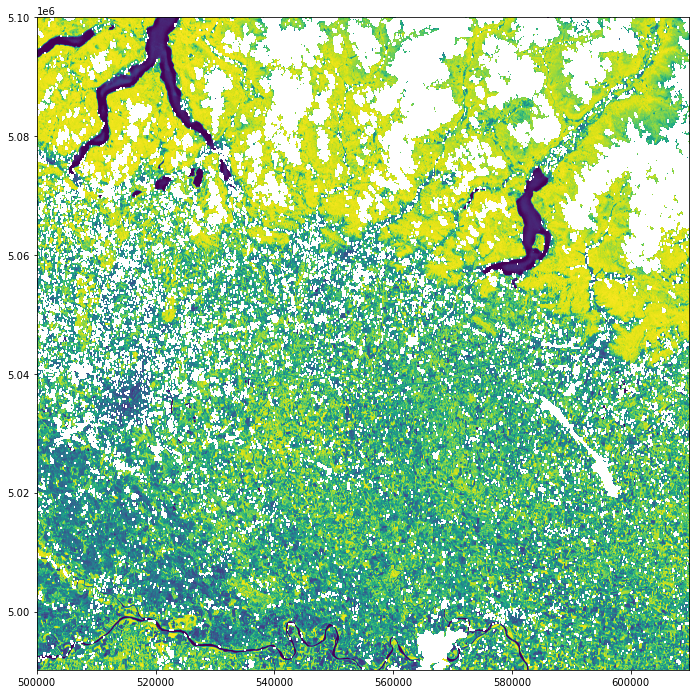

<AxesSubplot:>

In [39]:
# verify that the file was downloaded

import rasterio
from rasterio.plot import show
fp = r'/tmp/'+select_layer+'.tif'
img = rasterio.open(fp)
fig, ax = plt.subplots(1, figsize=(12, 12))
show(img)


---

# Copernicus C3S (optional) - slow download 

C3S is slow at downloading data

In [ ]:
f = open('keys.json')
keys = json.load(f)
c = cdsapi.Client("https://cds.climate.copernicus.eu/api/v2", "C3S_KEY")

# API request
params = {
        'format': 'netcdf',
        'product_type': 'reanalysis',
        'variable': 'temperature',
        'pressure_level':'1000',
        'year':['2020'],
        'month':['07'],
        'day': ['01'],
        'time': ['12:00'],
        'grid': [0.25, 0.25],
        'area': [48,6, 43, 12]}

# retrieve the location of the file
fl = c.retrieve('reanalysis-era5-pressure-levels', params) 

# load into memory 
with urlopen(fl.location) as f:
    ds = xr.open_dataset(f.read())


---

## Copernicus Land Cover WMS

In [ ]:
# load owslib library
from owslib.wms import WebMapService

# Create your WebMapService object
wms = WebMapService('https://viewer.globalland.vgt.vito.be/geoserver/ows?service=WMS&request=GetCapabilities')

#Show the number of available layers
sorted(list(wms.contents.keys()))

In [ ]:
%matplotlib inline
import os, sys
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

def getMap(layerName,bbox,filename):
    wms.getOperationByName('GetMap').formatOptions
    img = wms.getmap(layers=[layerName],
                 size=(600,300),
                 srs='EPSG:4326',
                 bbox=bbox,
                 format='image/png',
                 transparent=True)

    tmpfile = open(filename,'wb')
    tmpfile.write(img.read())
    tmpfile.close()
    
getMap('PV_MEP:PROBAV_S10_TOC_1KM_NDVI', (0,40,15,50), 'PV_MEP:PROBAV_S10_TOC_1KM_NDVI.png')
image_fore = mpimg.imread('PV_MEP:PROBAV_S10_TOC_1KM_NDVI.png')
fig = plt.figure(figsize=(12,7))

img_fore = plt.imshow(image_fore)

---

## Copernicus Land Cover WCS

Reference: https://land.copernicus.eu/global/product-access <br>
https://git.wur.nl/isric/soilgrids/soilgrids.notebooks <br>
https://cybergisxhub.cigi.illinois.edu/wp-content/uploads/2019/12/OGC_Services.html <br>
https://publicwiki.deltares.nl/display/OET/WCS+primer

In [ ]:
from owslib.wcs import WebCoverageService
wcs = WebCoverageService('https://viewer.globalland.vgt.vito.be/geoserver/ows?service=WCS&request=GetCapabilities')

In [ ]:
#Get the title of the service
print(wcs.identification.title)

# List the available first ten contents 
sorted(list(wcs.contents.keys()))[0:10]

In [ ]:
layerid = 'CGLS__ba300_v1_333m_FDOB_DEKAD'
wcs_layer = wcs.contents[layerid]

In [ ]:
#Title
print('Layer title :', wcs_layer.title)
#bounding box
print('BoundingBox :', wcs_layer.boundingBoxWGS84)
# supported data formats - we'll use geotiff
print('Formats :', wcs_layer.supportedFormats)

In [ ]:
format_wcs = 'image/jpeg'

output = wcs.getCoverage(identifier=[layerid, ], format=format_wcs)

In [ ]:
wcsfn = layerid + '.jpeg'
with open(wcsfn, 'wb') as fh:
    fh.write(output.read())

In [ ]:
wcsdt = xr.open_dataset(wcsfn)

print(wcsdt.data_vars)

plt.figure(figsize=(20,10))

wcsdt.Band1.plot()

plt.show()